Regression
====================

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
from __future__ import print_function, division

import numpy as np
import pandas as pd

import first
import thinkstats2
import thinkplot

%matplotlib inline

Let's load up the NSFG data again.

In [2]:
live, firsts, others = first.MakeFrames()
live.shape

(9148, 244)

And select live, full-term births.

In [3]:
live = live[live.prglngth>=37]
live.shape

(8001, 244)

And drop rows with missing data (just for the variables we want).

In [4]:
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])
live.shape

(7912, 244)

Check a few rows:

In [5]:
live.head()

,caseid,pregordr,howpreg_n,howpreg_p,moscurrp,nowprgdk,pregend1,pregend2,nbrnaliv,multbrth,...,laborfor_i,religion_i,metro_i,basewgt,adj_mod_basewgt,finalwgt,secu_p,sest,cmintvw,totalwgt_lb
0,1,1,NaN,NaN,NaN,NaN,6,NaN,1,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,8.8125
1,1,2,NaN,NaN,NaN,NaN,6,NaN,1,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,7.8750
2,2,1,NaN,NaN,NaN,NaN,5,NaN,3,5,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,9.1250
3,2,2,NaN,NaN,NaN,NaN,6,NaN,1,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,7.0000
4,2,3,NaN,NaN,NaN,NaN,6,NaN,1,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,6.1875


And summarize a few variables.

In [6]:
live[['agepreg', 'totalwgt_lb']].describe()

,agepreg,totalwgt_lb
count,7912.000000,7912.000000
mean,24.978917,7.482384
std,5.523504,1.169065
min,10.830000,0.125000
25%,20.580000,6.687500
50%,24.410000,7.437500
75%,28.910000,8.187500
max,44.080000,15.437500


Here's a scatterplot of age and birthweight, with parameters tuned to avoid saturation.

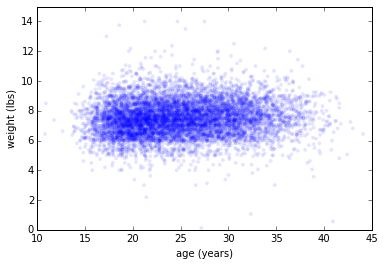

In [7]:
ages = live.agepreg
weights = live.totalwgt_lb
thinkplot.Scatter(ages, weights, alpha=0.1, s=15)
thinkplot.Config(xlabel='age (years)',
                 ylabel='weight (lbs)',
                 xlim=[10, 45],
                 ylim=[0, 15],
                 legend=False)

Mean of mother's age:

In [8]:
live['agepreg'].mean()

24.978916835186908

Mean and standard deviation of birthweight:

In [9]:
live['totalwgt_lb'].mean(), live['totalwgt_lb'].std()

(7.482384352881699, 1.1690646813035233)

And the coefficient of correlation:

In [10]:
thinkstats2.Corr(ages, weights)

0.085023137198215998

The Pandas `corr` function gets the same result:

In [11]:
live['totalwgt_lb'].corr(live['agepreg'])

0.085023137198215887

To see the relationship more clearly, we can group mother's age into 3-year bins and plot percentiles of birth weight for each bin.

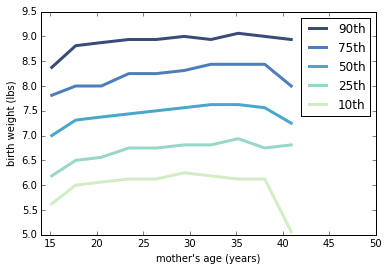

In [12]:
bins = np.arange(10, 48, 3)
indices = np.digitize(live.agepreg, bins)
groups = live.groupby(indices)

ages = [group.agepreg.mean() for i, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.totalwgt_lb) for i, group in groups][1:-1]

thinkplot.PrePlot(5)
for percent in [90, 75, 50, 25, 10]:
    weights = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(ages, weights, label=label)

thinkplot.Config(xlabel="mother's age (years)",
                 ylabel='birth weight (lbs)',
                 xlim=[14, 50],
                 legend=True)

The first and last points are not very reliable, because they represent fewer data points.

It looks like there is a generally positive relationshop between birth weight and mother's age, possibly leveling or dropping for older mothers.

We can get more information about the mothers by reading the respondents file, which contains one row per respondent.

In [13]:
def ReadFemResp(dct_file='2002FemResp.dct',
                dat_file='2002FemResp.dat.gz',
                nrows=None):
    """Reads the NSFG respondent data.

    dct_file: string file name
    dat_file: string file name

    returns: DataFrame
    """
    dct = thinkstats2.ReadStataDct(dct_file)
    df = dct.ReadFixedWidth(dat_file, compression='gzip', nrows=nrows)
    return df

There are 7643 respondents and 3087 variables about each.

In [14]:
resp = ReadFemResp()
resp.shape

(7643, 3087)

If we use the `caseid` variable as the index, we can look up respondents efficiently by id.

Here's what the first few rows look like:

In [15]:
resp.index = resp.caseid
resp.head()

,caseid,rscrinf,rdormres,rostscrn,rscreenhisp,rscreenrace,age_a,age_r,cmbirth,agescrn,...,pubassis_i,basewgt,adj_mod_basewgt,finalwgt,secu_r,sest,cmintvw,cmlstyr,screentime,intvlngth
caseid,,,,,,,,,,,,,,,,,,,,,
2298,2298,1,5,5,1,5,27,27,902,27,...,0,3247.916977,5123.759559,5556.717241,2,18,1234,1222,18:26:36,110.492667
5012,5012,1,5,1,5,5,42,42,718,42,...,0,2335.279149,2846.799490,4744.191350,2,18,1233,1221,16:30:59,64.294000
11586,11586,1,5,1,5,5,43,43,708,43,...,0,2335.279149,2846.799490,4744.191350,2,18,1234,1222,18:19:09,75.149167
6794,6794,5,5,4,1,5,15,15,1042,15,...,0,3783.152221,5071.464231,5923.977368,2,18,1234,1222,15:54:43,28.642833
616,616,1,5,4,1,5,20,20,991,20,...,0,5341.329968,6437.335772,7229.128072,2,18,1233,1221,14:19:44,69.502667


Now we can join the tables, using the `caseid` from each pregnancy record to find the corresponding respondent and (abstractly) copy over the additional variables.

So the joined table has one row for each pregnancy and all the columns from both tables.

In [16]:
join = live.join(resp, on='caseid', rsuffix='_r')
join.shape

(7912, 3331)

The encoding for `screentime` is a colon-separated timestamp.

In [17]:
join.screentime.head()

0    19:56:43
1    19:56:43
2    14:54:03
3    14:54:03
4    14:54:03
Name: screentime, dtype: object

If we convert to a datetime object, we avoid some processing problems later.

In [18]:
join.screentime = pd.to_datetime(join.screentime)
join.screentime.head()

0   2015-10-07 19:56:43
1   2015-10-07 19:56:43
2   2015-10-07 14:54:03
3   2015-10-07 14:54:03
4   2015-10-07 14:54:03
Name: screentime, dtype: datetime64[ns]

To estimate the effect of mother's age on birthweight, we can use a simple least squares fit.

In [19]:
ages = join.agepreg
weights = join.totalwgt_lb

inter, slope = thinkstats2.LeastSquares(ages, weights)
inter, slope, slope*16*10

(7.0328792906633737, 0.017995378469939118, 2.879260555190259)

The slope is almost 3 ounces per decade.

We can do the same thing using Ordinary Least Squares from statsmodels:

In [20]:
import statsmodels.formula.api as smf

formula = ('totalwgt_lb ~ agepreg')
results = smf.ols(formula, data=join).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            totalwgt_lb   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     57.60
Date:                Wed, 07 Oct 2015   Prob (F-statistic):           3.58e-14
Time:                        15:40:17   Log-Likelihood:                -12433.
No. Observations:                7912   AIC:                         2.487e+04
Df Residuals:                    7910   BIC:                         2.488e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      7.0329      0.061    115.940      0.000         6.914     7.152
agepreg        0.0180      0.002      7.589      0.000         0.013     0.023
==============================================================================
Omnibus:                      381.292   Durbin-Watson:                   1.586
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1098.730
Skew:                           0.215   Prob(JB):                    2.59e-239
Kurtosis:                       4.774   Cond. No.                         119.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The results object contains the parameters (and all the other info in the table):

In [21]:
inter, slope = results.params
inter, slope

(7.032879290663371, 0.017995378469939035)

And the results are consistent with my implementation:

In [22]:
slope * 16 * 10           # slope in ounces per decade

2.8792605551902457

We can use a boolean variable as a predictor:

In [23]:
join['isfirst'] = (join.birthord == 1)

formula = 'totalwgt_lb ~ isfirst'
results = smf.ols(formula, data=join).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            totalwgt_lb   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     12.34
Date:                Wed, 07 Oct 2015   Prob (F-statistic):           0.000445
Time:                        15:40:18   Log-Likelihood:                -12456.
No. Observations:                7912   AIC:                         2.492e+04
Df Residuals:                    7910   BIC:                         2.493e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           7.5265      0.018    414.288      0.000         7.491     7.562
isfirst[T.True]    -0.0924      0.026     -3.513      0.000        -0.144    -0.041
==============================================================================
Omnibus:                      364.721   Durbin-Watson:                   1.581
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1001.182
Skew:                           0.218   Prob(JB):                    3.95e-218
Kurtosis:                       4.687   Cond. No.                         2.57
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

First babies are lighter by about 1.5 ounces.

In [24]:
results.params['isfirst[T.True]'] * 16

-1.4779760012473198

And we can make a model with multiple predictors.

In [25]:
formula = 'totalwgt_lb ~ agepreg + isfirst'
results = smf.ols(formula, data=join).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            totalwgt_lb   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     29.50
Date:                Wed, 07 Oct 2015   Prob (F-statistic):           1.72e-13
Time:                        15:40:18   Log-Likelihood:                -12433.
No. Observations:                7912   AIC:                         2.487e+04
Df Residuals:                    7909   BIC:                         2.489e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           7.0719      0.069    102.463      0.000         6.937     7.207
isfirst[T.True]    -0.0327      0.028     -1.185      0.236        -0.087     0.021
agepreg             0.0171      0.002      6.826      0.000         0.012     0.022
==============================================================================
Omnibus:                      382.030   Durbin-Watson:                   1.585
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1103.586
Skew:                           0.214   Prob(JB):                    2.29e-240
Kurtosis:                       4.779   Cond. No.                         138.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

If we control for mother's age, the difference in weight for first babies is cut to about 0.5 ounces (and no longer statistically significant).

In [26]:
results.params['isfirst[T.True]'] * 16

-0.52389693286041505

The relationship with age might be non-linear.  Adding a quadratic term helps a little, although note that the $R^2$ values for all of these models are very small.

In [27]:
join['age2'] = join.agepreg**2

formula = 'totalwgt_lb ~ agepreg + age2'
results = smf.ols(formula, data=join).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            totalwgt_lb   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     37.48
Date:                Wed, 07 Oct 2015   Prob (F-statistic):           6.30e-17
Time:                        15:40:18   Log-Likelihood:                -12425.
No. Observations:                7912   AIC:                         2.486e+04
Df Residuals:                    7909   BIC:                         2.488e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      6.0378      0.247     24.428      0.000         5.553     6.522
agepreg        0.0979      0.019      5.050      0.000         0.060     0.136
age2          -0.0015      0.000     -4.153      0.000        -0.002    -0.001
==============================================================================
Omnibus:                      378.969   Durbin-Watson:                   1.587
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1074.412
Skew:                           0.219   Prob(JB):                    4.95e-234
Kurtosis:                       4.751   Cond. No.                     1.36e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now we can combine the quadratic age model with `isfirst`

In [28]:
formula = 'totalwgt_lb ~ agepreg + age2 + isfirst'
results = smf.ols(formula, data=join).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            totalwgt_lb   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     25.12
Date:                Wed, 07 Oct 2015   Prob (F-statistic):           3.61e-16
Time:                        15:40:18   Log-Likelihood:                -12425.
No. Observations:                7912   AIC:                         2.486e+04
Df Residuals:                    7908   BIC:                         2.488e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           6.0795      0.256     23.775      0.000         5.578     6.581
isfirst[T.True]    -0.0177      0.028     -0.637      0.524        -0.072     0.037
agepreg             0.0957      0.020      4.865      0.000         0.057     0.134
age2               -0.0015      0.000     -4.030      0.000        -0.002    -0.001
==============================================================================
Omnibus:                      379.403   Durbin-Watson:                   1.586
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1077.436
Skew:                           0.219   Prob(JB):                    1.09e-234
Kurtosis:                       4.754   Cond. No.                     1.41e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now the effect is cut to less that a third of an ounce, and very plausibly due to chance.

In [29]:
results.params['isfirst[T.True]'] * 16

-0.28383607712278636

Here's the best model I found, combining all variables that seemed plausibly predictive.

In [30]:
formula = ('totalwgt_lb ~ agepreg + age2 + C(race) + '
           'nbrnaliv>1 + paydu==1 + totincr')
results = smf.ols(formula, data=join).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            totalwgt_lb   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     54.63
Date:                Wed, 07 Oct 2015   Prob (F-statistic):           1.11e-76
Time:                        15:40:19   Log-Likelihood:                -12275.
No. Observations:                7912   AIC:                         2.457e+04
Df Residuals:                    7904   BIC:                         2.462e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept                6.0829      0.243     25.022      0.000         5.606     6.559
C(race)[T.2]             0.3625      0.031     11.649      0.000         0.302     0.424
C(race)[T.3]             0.2434      0.050      4.833      0.000         0.145     0.342
nbrnaliv > 1[T.True]    -1.0779      0.121     -8.889      0.000        -1.316    -0.840
paydu == 1[T.True]       0.0985      0.030      3.255      0.001         0.039     0.158
agepreg                  0.0714      0.019      3.741      0.000         0.034     0.109
age2                    -0.0012      0.000     -3.341      0.001        -0.002    -0.000
totincr                  0.0132      0.004      3.452      0.001         0.006     0.021
==============================================================================
Omnibus:                      453.110   Durbin-Watson:                   1.609
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1254.734
Skew:                           0.300   Prob(JB):                    3.45e-273
Kurtosis:                       4.856   Cond. No.                     1.36e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

All predictors are statistically significant, so the effects could be legit, but the $R^2$ value is still very small: this model doesn't provide much help for the office pool.

Logistic regression
-------------------

Let's say we want to predict the sex of a baby based on information about the mother.

I'll start by creating a binary dependent variable, `isboy`, and checking for dependence on mother's age:

In [31]:
live['isboy'] = (live.babysex==1).astype(int)
model = smf.logit('isboy ~ agepreg', data=live)    
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.692981
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  isboy   No. Observations:                 7912
Model:                          Logit   Df Residuals:                     7910
Method:                           MLE   Df Model:                            1
Date:                Wed, 07 Oct 2015   Pseudo R-squ.:               1.352e-05
Time:                        15:40:19   Log-Likelihood:                -5482.9
converged:                       True   LL-Null:                       -5482.9
                                        LLR p-value:                    0.7002
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.0038      0.104     -0.036      0.971        -0.208     0.200
agepreg        0.0016      0.004      0.385      0.700        -0.006     0.010
==============================================================================
"""

The estimated parameter is 0.0016, which is small and not statistically significant.  So the apparent relationship might be due to chance.

But for the sake of the example, I'll take it at face value and work out the effect on the prediction.

A parameter in a logistic regression is a log odds ratio, so we can compute the odds ratio for a difference of 10 years in mother's age:

In [32]:
log_odds_ratio = results.params['agepreg'] * 10
odds_ratio = np.exp(log_odds_ratio)
odds_ratio

1.0158023740467292

And we can use the odds ratio to update a prior probability.  A mother at the mean age has a 51% chance of having a boy.

In the case a mother who is 10 years older has a 51.4% chance.

In [33]:
p = 0.51
prior_odds = p / (1-p)
post_odds = prior_odds * odds_ratio
p = post_odds / (post_odds + 1)
p

0.51391744178527499

I searched for other factors that might be predictive.  The most likely candidates turn out not to be statistically significant.

In [34]:
formula = 'isboy ~ agepreg + hpagelb + birthord + C(race)'
model = smf.logit(formula, data=live)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.692727
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  isboy   No. Observations:                 7826
Model:                          Logit   Df Residuals:                     7820
Method:                           MLE   Df Model:                            5
Date:                Wed, 07 Oct 2015   Pseudo R-squ.:               0.0004249
Time:                        15:40:19   Log-Likelihood:                -5421.3
converged:                       True   LL-Null:                       -5423.6
                                        LLR p-value:                    0.4654
================================================================================
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept       -0.0639      0.111     -0.575      0.565        -0.282     0.154
C(race)[T.2]    -0.0135      0.054     -0.250      0.803        -0.120     0.092
C(race)[T.3]    -0.0158      0.089     -0.178      0.859        -0.190     0.158
agepreg         -0.0056      0.006     -0.963      0.336        -0.017     0.006
hpagelb          0.0069      0.004      1.542      0.123        -0.002     0.016
birthord         0.0297      0.024      1.264      0.206        -0.016     0.076
================================================================================
"""

Again, taking these parameters at face values, we can use the model to make predictions.

The baseline strategy is to always guess boy, which yields accuracy of 50.8%

In [35]:
exog = pd.DataFrame(model.exog, columns=model.exog_names)
endog = pd.DataFrame(model.endog, columns=[model.endog_names])

actual = endog['isboy']
baseline = actual.mean()
baseline

0.5079223102478917

`results.predict` uses the model to generate predictions for the data.

Adding up the correct positive and negative predictions, we get accuracy 51.3%

In [36]:
predict = (results.predict() >= 0.5)
true_pos = predict * actual
true_neg = (1 - predict) * (1 - actual)

acc = (sum(true_pos) + sum(true_neg)) / len(actual)
acc

0.51316125734730389

And we can use the model to generate a prediction for the office pool.

Suppose your hypothetical coworker is is 39 years old and white, her husband is 30, and they are expecting their first child.

In [37]:
columns = ['agepreg', 'hpagelb', 'birthord', 'race']
new = pd.DataFrame([[39, 30, 1, 2]], columns=columns)
y = results.predict(new)
y

array([ 0.48485192])

This is one of the few scenarios where the model predicts that the baby will be a girl.

But given the low accuracy of the model (and the likelihood that it is overfit to the data) this model would not be much help in the pool.